# L2 Comprehensive exercise

Download the data from the Raisin Dataset: https://archive.ics.uci.edu/dataset/850/raisin

Using the attached code, split the data into train and validation, then train a logistic regression model.

Using this model, do the following using the F1 score:
1) Compute overall F1 score.
2) Choose any three features, split by the average value, and compute the F1 score on each slice. This should result in six F1 scores.
3) Write a brief model card giving high level details about the model, intended use metrics, data, and potential bias.


> Use 'udacity' environment defined by 'requirements.txt' file.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
import sklearn
print(f"Skikit-learn version {sklearn.__version__}")

Skikit-learn version 1.7.2


In [2]:
# print(os.getcwd())
#data = pd.read_csv("exercise_data/Raisin_Dataset.csv")
data = pd.read_excel("exercise_data/Raisin_Dataset.xlsx")
print(f"Data shape: {data.shape}")
display(data.head())

y = data.pop("Class")
print(f"Unique classes {y.unique()}")

# Split the data into train and validation, stratifying on the target feature.
X_train, X_val, y_train, y_val = train_test_split(data, y, stratify=y, random_state=23)
print(f"Train data size: {X_train.shape[0]}")
print(f"Val data shape: {X_val.shape[0]}")

Data shape: (900, 8)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


Unique classes ['Kecimen' 'Besni']
Train data size: 675
Val data shape: 225


In [3]:
# Get a high level overview of the data. This will be useful for slicing.
X_train.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,87210.494815,427.650555,254.414345,0.779895,90407.262222,0.701092,1159.625772
std,38388.571707,110.506268,49.752074,0.088938,39602.352484,0.050807,261.820857
min,25387.000000,225.629541,144.618672,0.348730,26139.000000,0.454189,619.074000
25%,59032.500000,343.732369,218.692197,0.740516,61466.500000,0.671134,964.835500
50%,79057.000000,405.936594,247.352044,0.797864,81779.000000,0.709949,1117.107000
75%,103790.500000,493.185891,280.180509,0.840452,108022.500000,0.735886,1302.416500
max,235047.000000,843.956653,492.275279,0.923770,239093.000000,0.830632,2253.557000


## Model fitting

In [4]:
lr = LogisticRegression(max_iter=1000, random_state=23)
lb = LabelBinarizer()

# Binarize the target feature.
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)

# Train Logistic Regression.
lr.fit(X_train, y_train.ravel())

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,23
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Overall F1 score.

In [5]:
scores = lr.predict_proba(X_val) # Returns the probabilities of each class for the input samples.
pred = lr.predict(X_val) # Returns the predicted class labels for the input samples.

f1 = f1_score(y_true=y_val, y_pred=pred, average='macro')
print(f"F1 score: {f1:.4f}")

f1_per_class = f1_score(y_val, pred, average=None)
print(f"F1 score per class: {f1_per_class}")

print(classification_report(y_true=y_val, y_pred=pred))

F1 score: 0.8622
F1 score per class: [0.85972851 0.86462882]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       112
           1       0.85      0.88      0.86       113

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.86      0.86      0.86       225



## Confusion Matrix

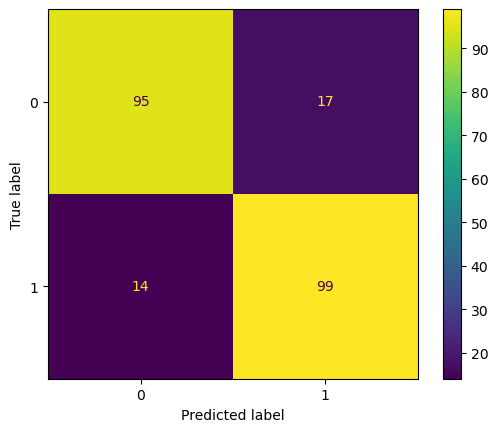

In [6]:
cm = confusion_matrix(y_val, pred, labels=[0, 1])
ConfusionMatrixDisplay(cm).plot()

## Feature Importance

In [7]:
# Print feature importance with labels
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lr.coef_[0]  # Coefficients for the first class
})

# Sort by importance (absolute value) for better readability
feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)

print(feature_importance)

           Feature  Importance
3     Eccentricity    0.339225
2  MinorAxisLength    0.092854
1  MajorAxisLength    0.058877
6        Perimeter   -0.041560
5           Extent    0.010720
0             Area   -0.000634
4       ConvexArea    0.000542


## F1 score for slices 

Choose any three features, split by the average value, and compute the F1 score on each slice. This should result in six F1 scores.

In [8]:
df_f1 = pd.DataFrame(columns=['feature', 'median', 'avg', 'f1_above_avg', 'f1_below_avg'])

for feature in list(X_val.columns):
    feature_mean = X_val[feature].mean()
    feature_median = X_val[feature].median()
    above_average = X_val[feature]>feature_mean
    f1_above = f1_score(y_true=y_val[above_average], y_pred=pred[above_average])
    f1_below = f1_score(y_true=y_val[~above_average], y_pred=pred[~above_average])
    df_f1.loc[len(df_f1)] = [feature, feature_median, feature_mean, f1_above, f1_below]

    #print(f"{feature}") 
    #print(f" -mean: {feature_mean:.3f} \n -F1 score > avg: {f1_above:.3f}, < avg: {f1_below:.3f}\n")

df_f1 = df_f1.sort_values(by='f1_above_avg', ascending=False)
display(df_f1)

,feature,median,avg,f1_above_avg,f1_below_avg
5,Extent,0.700769,0.694755,0.902778,0.800000
3,Eccentricity,0.802035,0.786485,0.761905,0.924138
2,MinorAxisLength,249.390880,254.709496,0.666667,0.897959
0,Area,77310.000000,89585.026667,0.363636,0.889908
4,ConvexArea,80497.000000,93522.573333,0.333333,0.894009
6,Perimeter,1126.765000,1184.749227,0.222222,0.890909
1,MajorAxisLength,413.496365,440.768137,0.000000,0.904110


From the slices above, we see that model performs significantly better on raisin sizes below average.

Features with low F1 performance for slices above average have their median lower than the average indicating to missing data.

## Model Card

### Model Details

Logistic regression trained with default scikit-learn parameters. Scikit-learn version 1.7.2.

### Intended Use

Model is to be used for classifying two types of rasins.

### Metrics

F1 classification with macro average of 0.86.

When analyzing across slices, model performance is higher for raisins below average size. 

### Data

# L2 Comprehensive exercise

Dataset obtained from the Raisin Dataset: https://archive.ics.uci.edu/dataset/850/raisin.

### Bias

The majority of raisings are below the average size. This could be a potential source of bias but more subject matter expertise may be necessary.